In [1]:
from datetime import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import numpy as np
import mplfinance as mpf
import pandas as pd
from ta.volatility import BollingerBands

In [2]:
# No keys required for crypto data
client = CryptoHistoricalDataClient()
# Creating request object
request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD"],
  timeframe=TimeFrame.Minute,
  start=datetime.fromisoformat('2025-03-02T09:00:00-05:00'),
  end=datetime.fromisoformat('2025-03-02T13:00:00-05:00')
)
# Retrieve daily bars for Bitcoin in a DataFrame and printing it
btc_bars = client.get_crypto_bars(request_params)
# Convert to dataframe
df = btc_bars.df
# Update indexes to use only timestamp, as we are doing single symbol analysis
df = df.droplevel('symbol')
df.index = df.index.tz_convert('US/Eastern')

In [15]:
from typing import Callable

def marker_signal_from_series(alpaca_df: pd.Series, transform_pair: Callable[[tuple[datetime, float]], float]) -> list[float]:
    source_iterable = alpaca_df.items()
    marker_signal: list[float] = list(map(transform_pair, source_iterable))
    return marker_signal

def datetime_marker_signal(series: pd.Series, datetimes: list[datetime]) -> list[float]:
    def transform_pair(dt_pair: tuple[datetime, float]):
        date, value =  dt_pair
        #return value * 0.99 if date in datetimes else np.nan
        return series.max() * 1.003 if date in datetimes else np.nan
    return marker_signal_from_series(series, transform_pair)

In [29]:
# Add markers at key points
datetimes_str: list[str] = ['2025-03-02T10:24:00-05:00', '2025-03-02T12:11:00-05:00']
datetimes: list[datetime] = [datetime.fromisoformat(x) for x in datetimes_str]
marker_signal = datetime_marker_signal(df.low, datetimes)
# Subplot for markers
# markers = mpf.make_addplot(marker_signal, type='scatter', markersize=80, marker="*", color='blue', panel=0)
vlines = dict(vlines=datetimes,linewidths=[8,8],alpha=0.15)

In [11]:
# Bollinger Bands
indicator_bb = BollingerBands(close=df.close, window=20, window_dev=2)
bollinger_bands = pd.DataFrame({
    'upper': indicator_bb.bollinger_hband(),
    'lower': indicator_bb.bollinger_lband()
})
def generate_high_marker_signal(series: pd.Series, comparison: pd.Series) -> list[float]:
    skip = False # skip repeated markers
    signal = []
    for date,value in series.items():
        comparison_value = comparison.loc[date]
        if value > comparison_value and skip is False:
            signal.append(value * 1.003)
            skip = True
        else:
            signal.append(np.nan)
            if skip is True: skip = False
    return signal
def generate_low_marker_signal(series: pd.Series, comparison: pd.Series) -> list[float]:
    skip = False # skip repeated markers
    signal = []
    for date,value in series.items():
        comparison_value = comparison.loc[date]
        if value < comparison_value and skip is False:
            signal.append(value * 0.998)
            skip = True
        else:
            signal.append(np.nan)
            if skip is True: skip = False
    return signal
bb_marker_high_signal = generate_high_marker_signal(df.close, indicator_bb.bollinger_hband())
bb_marker_low_signal = generate_low_marker_signal(df.close, indicator_bb.bollinger_lband())
# Subplot for BB
bb_subplot = mpf.make_addplot(bollinger_bands)
bb_high_marker_subplot = mpf.make_addplot(bb_marker_high_signal, type='scatter', markersize=20, marker="v", color='green', panel=0)
bb_low_marker_subplot = mpf.make_addplot(bb_marker_low_signal, type='scatter', markersize=20, marker="^", color='red', panel=0)

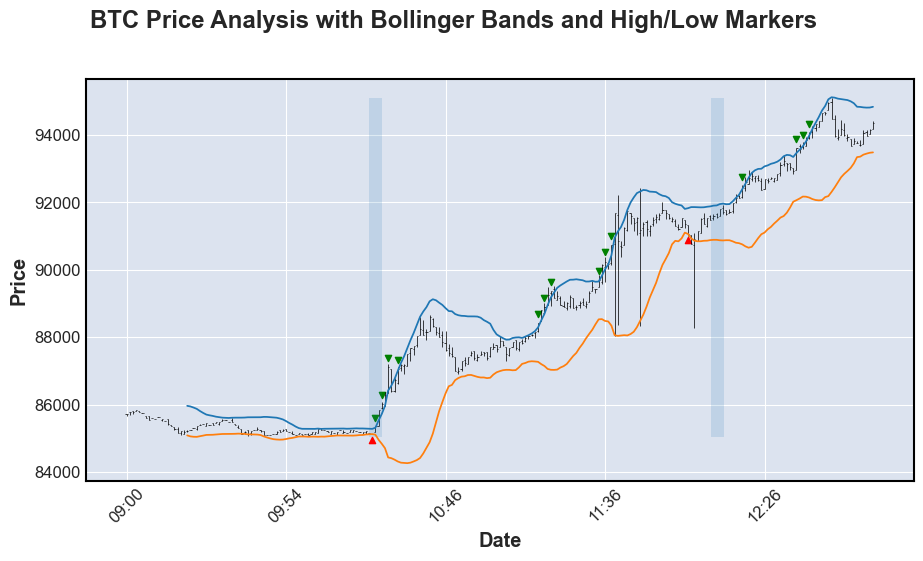

In [36]:
# Plot everything
subplts = [bb_subplot, bb_high_marker_subplot, bb_low_marker_subplot]
plt = mpf.plot(
    data=df, figratio=(10, 5),
    addplot=subplts,
    vlines=vlines,
    xlabel="Date",
    ylabel="Price",
    title="BTC Price Analysis with Bollinger Bands and High/Low Markers",
)